# More Analysis!
This post builds on the analysis I started in the last post. A lot of the graphs here were first envisioned by Adam, and I've added to his efforts. The point of this post is to draw out important relationships between the explanatory variables and win share. In the next post I'll be putting up models to finally evaluate who is the best drafting GM since the NBA merger. 

## Forgot to mention the limitation of the exec draft experience column
This column is counting up for each year that a GM gets to draft, presumably because more experienced GM's would draft better, as discussed before. An issue with this is that I am assuming that every GM started in 1976 since that's when my data starts, but obviously this is not true. I may try to account for this by lagging GM's experience in later analysis, but for my purposes, I'm not going to worry about it much unless GM experience proves to be a pretty significant predictor of player quality.

In [1]:
# Needed libraries
library(RCurl)
library(dplyr)
library(ggplot2)
library(tidyr)
library(modelr)
thunder <- c("dodgerblue", "dodgerblue2", "dodgerblue3", "dodgerblue4", "darkorange4", "darkorange3", "darkorange2", "darkorange")

Loading required package: bitops

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:RCurl’:

    complete



In [2]:
# Loading the dataset in R using 'getURL' from RCurl
x <- getURL("https://raw.githubusercontent.com/rvino/blog_data/master/NBA_Data/1976_to_2015_Draftees_edit2.csv")
df <- read.csv(text = x)

## More Graphs and Stats
The majority of this post is graphs. I'm pretty in love with R's ggplot right now and can't help but try to put anything and everything into a graph. That being said, I do a little dry, basic stat comparisons to get a sense of the data and to show how certain commands can be used in R.

I've also shifted away from showing errors in my code in carrying out these portions of my analysis for a number of reasons:
1. In running analysis there are a lot fewer errors to deal with.
2. The errors that do pop up aren't very informative, rather they are generally errors in syntax and generally don't require a lot of poking around to figure out what went wrong

The more interesting errors in the analysis are likely to be things I overlooked. In building up this analysis I try to explain why I make certain choices and show why I made those choices based on the data, but there are likely to be factors that I've overlooked or that I've misinterpreted. This is an area that I think requires not only more experience, but critiques from others.

Anyway, onto the analysis

In [3]:
# Limiting my data to the first 60 picks
df <- df %>%
    subset(Pk < 61)

## T-tests!
So I thought I'd do some  t-tests looking at whether there is a difference in win share between players that went to college and those that did not. It's a simple t-test since there two well-defined groups. It's also an interesting question of whether players that attend college will be more likely to have a higher average win share than those that did not. We might expect for players that attend college to have higher win shares because (1) they have more years of development and thus were more ready to contribute to a team and (2) the added years of experience are years of vetting allowing GM's to make more informed decisions on who to bring into the league. But it might also be the case that going to college is simply another few years for a player to miss out developing at the highest level and building total win share.

One thing to account for in these t-tests is that players skipping college to enter the NBA right after high school varied over time. Historically, all players attended college, but starting in the 90's and with the success of players like Kevin Garnett, more and more players decided to enter the draft right after high school. The NBA acted against this in 2005 by setting a requirement that players be at least 19 years old. This essentially forces players to go to college for a year or to go to a foreign league for a year. But the impact of the shift in culture of entering the NBA directly likely skews results. Since players in the 1980s and after 2005 play at least one extra year of basketball these parts of the groups are categorically different. Michael Jordan was drafted in 1985 after three years at North Carolina, but it's possible that had the option been available to enter the NBA right after high school that Jordan would have taken it, and been just as or more successful. The cultural influences and later the NBA rule altered the pool such that comparing these players with those in the 90's and early 00's, when entering the NBA directly from high school was more common, are not directly comparable.

The graph below shows this variation over time. Ideally, I would be able to separate out those players that never played in college from players that came from abroad, but that would require more scraping and possibly manual manipulation as well. It's likely more accurate to run the t-test for players drafted between 1989 and 2005 (those players before 1989 with a zero for attend_college are mostly foreign imports) and thus that is what I present below. 

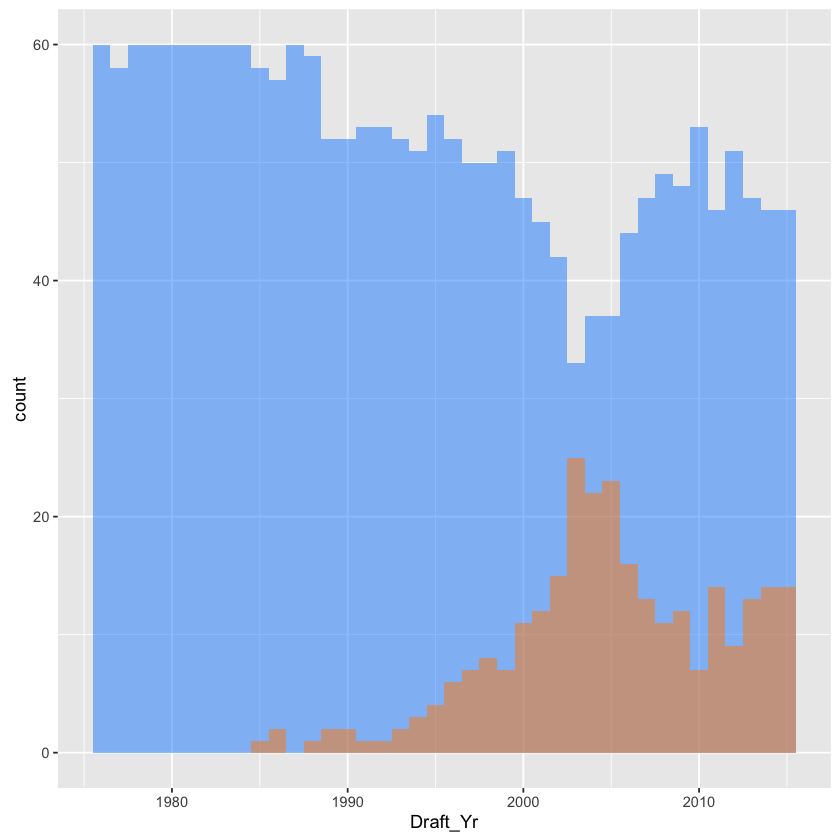

In [4]:
df %>%
    ggplot()+
        geom_histogram(data = subset(df, attend_college == 1), aes(x = Draft_Yr, fill = "College"), binwidth = 1, fill = "dodgerblue", alpha = 0.5)+
        geom_histogram(data = subset(df, attend_college == 0), aes(x = Draft_Yr, fill = "No college"), binwidth = 1, fill = "darkorange", alpha = 0.5)


In [5]:
ndf <- df %>%
    filter(df$Draft_Yr >= 1989 & df$Draft_Yr < 2006)
t.test(ndf$WS_per_game ~ ndf$attend_college)


	Welch Two Sample t-test

data:  ndf$WS_per_game by ndf$attend_college
t = -0.31569, df = 180.35, p-value = 0.7526
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.02606520  0.01887522
sample estimates:
mean in group 0 mean in group 1 
     0.04925828      0.05285327 


In [6]:
t.test(ndf$Win.Share ~ ndf$attend_college)


	Welch Two Sample t-test

data:  ndf$Win.Share by ndf$attend_college
t = 1.6276, df = 179.16, p-value = 0.1054
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.170898 12.197041
sample estimates:
mean in group 0 mean in group 1 
       23.75894        18.24587 


I'll present one t-test without controlling for year just to show the impact of including categorically different groups of players in the analysis.

In [7]:
t.test(df$WS_per_game ~ df$attend_college)


	Welch Two Sample t-test

data:  df$WS_per_game by df$attend_college
t = -1.1151, df = 322.97, p-value = 0.2656
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.021220805  0.005867428
sample estimates:
mean in group 0 mean in group 1 
     0.04207914      0.04975583 


Now some graphs to look at the relationship between attending college and not attending on win share.

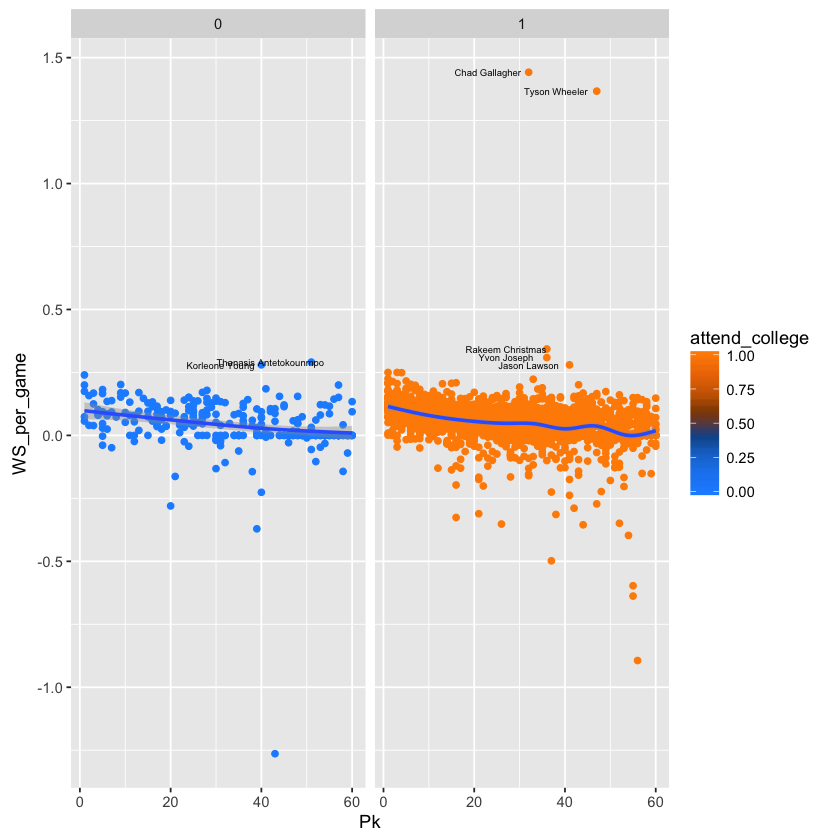

In [8]:
# Graph relationships WS - attend college
df %>%
    ggplot(aes(x = Pk, y = WS_per_game))+
        geom_point(aes(x = Pk, y = WS_per_game, color = attend_college))+
        geom_smooth()+
        geom_text(data=subset(df, WS_per_game > 0.25), aes(Pk,WS_per_game,label=Player), size = 2, nudge_x = -9)+
        facet_grid(.~attend_college)+
        scale_colour_gradientn(colours=thunder)

## Who are these guys?
Some interesting names are popping out from these graphs: Korleone Young, Thanasis Antetokunmpo (not the Greek Freak), Jason Lawton, Yvon Joseph, and Rakeem Christmas. I've never heard of any of these guys, which likely points to them being abnormalities in the data that should be accounted for in some way.

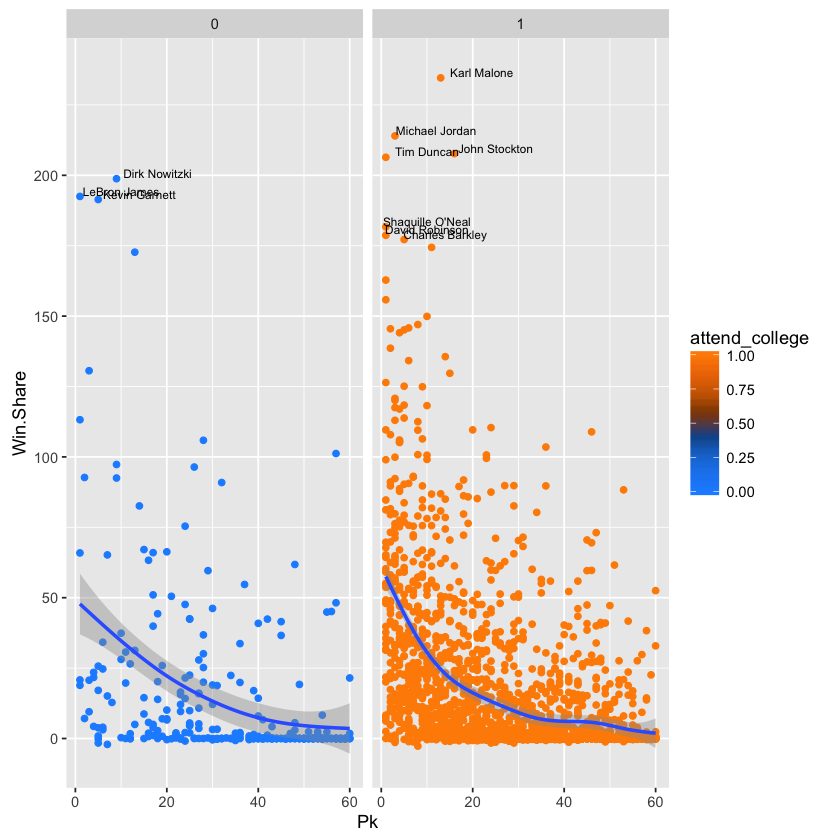

In [9]:
df %>%
    ggplot(aes(x = Pk, y = Win.Share))+
        geom_point(aes(x = Pk, y = Win.Share, color = attend_college))+
        geom_smooth()+
        geom_text(data=subset(df, Win.Share > 175), aes(Pk,Win.Share,label=Player), nudge_y = 2, nudge_x = 9, size = 2.5)+
        facet_grid(.~attend_college)+
        scale_colour_gradientn(colours=thunder)

## These guys make sense
Whereas the last graph pulled out names that I'd never heard of, the names above are well-known players and it makes sense that these guys, with long, historic careers would be coming out in the data. Note Karl Marlone and John Stockton, they play a big part in the later models looking at who is the best drafting GM since the NBA merger.

## Concern - the number of games played swamping the effects
The difference in names that come out of the last two graphs point to a potential issue in the data, especially since using win share per game pulled out names of obscure players. This leads me to believe that just as we saw that Chad Gallagher was apparently an all star level player over 2 games and 3 minutes of play, players with very few games may be swamping the win share per game stat with huge outliers. Let's check this out.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


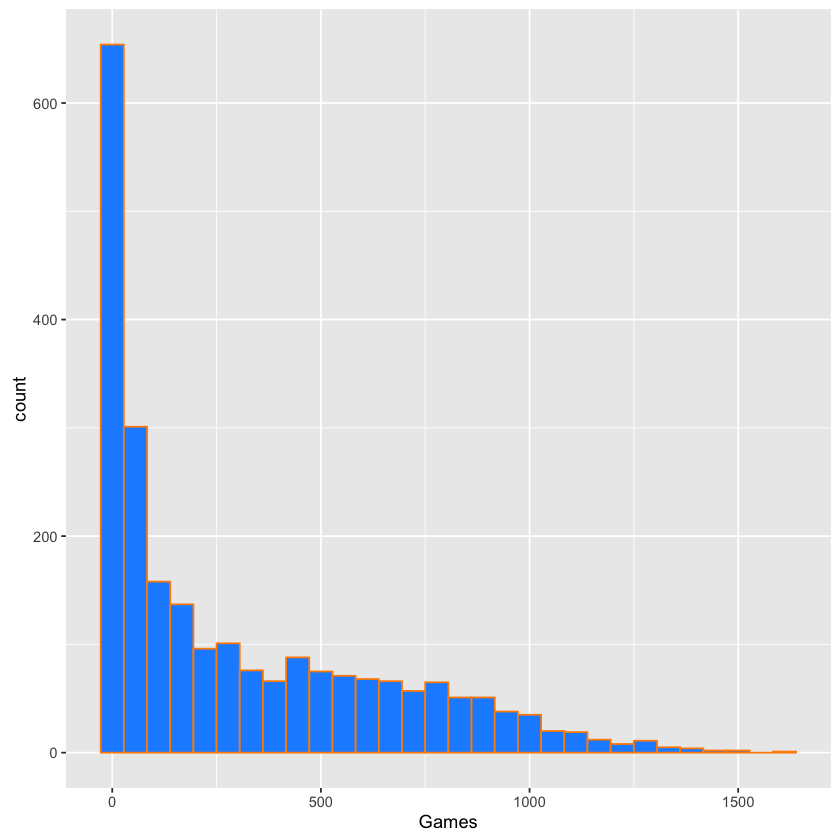

In [10]:
df %>%
    ggplot(aes(x = Games))+
        geom_histogram(fill = "dodgerblue", color = "darkorange")

As we can see in the histogram above, there is a huge number of players that have played very few games. These players are likely to be outliers in win share per game, potentially having one or two amazing (or horrific) games that mess with outliers. Let's zoom in on players with less than 250 games to see how they break down.

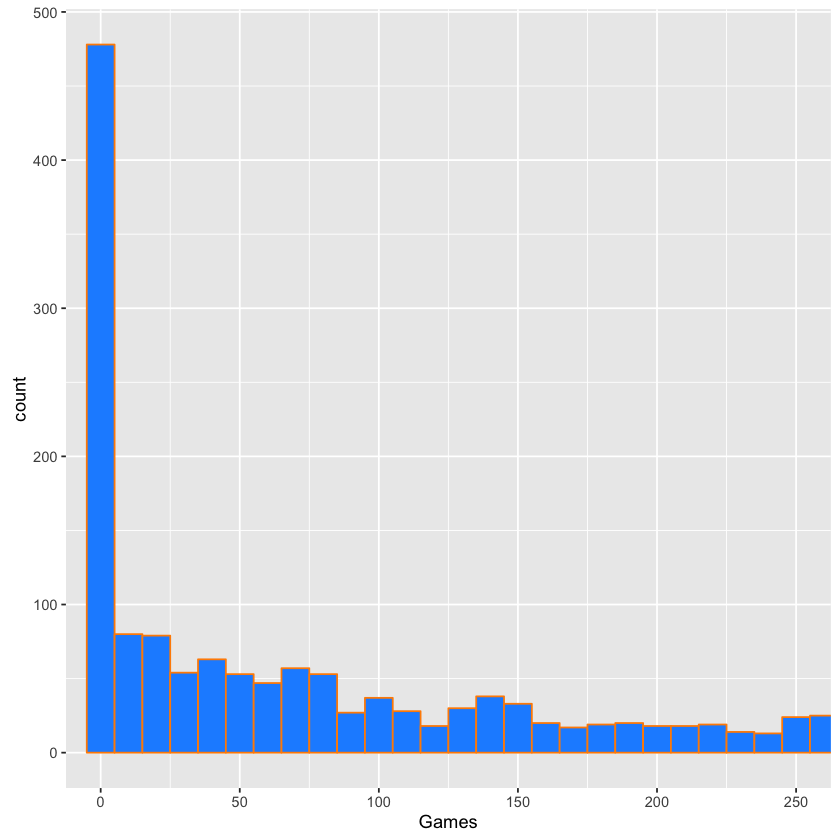

In [11]:
# Zooming in on players with less than 250 games
df %>%
    ggplot(aes(x = Games))+
        geom_histogram(binwidth = 10, fill = "dodgerblue", color = "darkorange")+
        coord_cartesian(xlim = c(0, 250))

As we can see, the huge number of players with few games is those with less than 10 games. This makes sense based on short term contracts that many players sign. The NBA allows teams to sign players to 10 day contracts in order to fill roster spaces, so there are likely to be many journey-men players that maybe were signed to one of these contracts and maybe got on the floor for a few minutes or a few games.

In [12]:
# Let's knock out at least those players who played 10 games or fewer and see what the data looks like
newdf <- df %>%
    filter(Games > 10)

First a graph showing the relationship between win share per game and the number of games played for all players. We would expect a positive correlation between games played and win share per game, as better players are more likely to play more games!

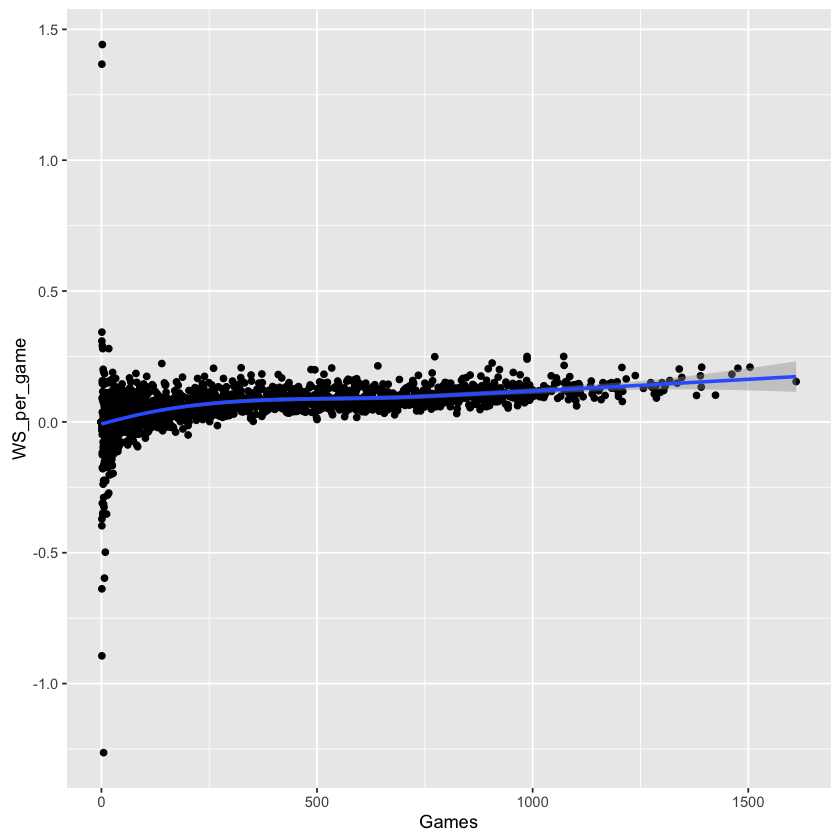

In [13]:
# Before knocking out the players with 10 or fewer games played
df %>%
    ggplot(aes(x = Games, y = WS_per_game))+
        geom_point()+
        geom_smooth()

A positive relationship, but it doesn't appear to be as strong as we might expect. So now let's look at the relationship after we knock out players with fewer than 10 games played.

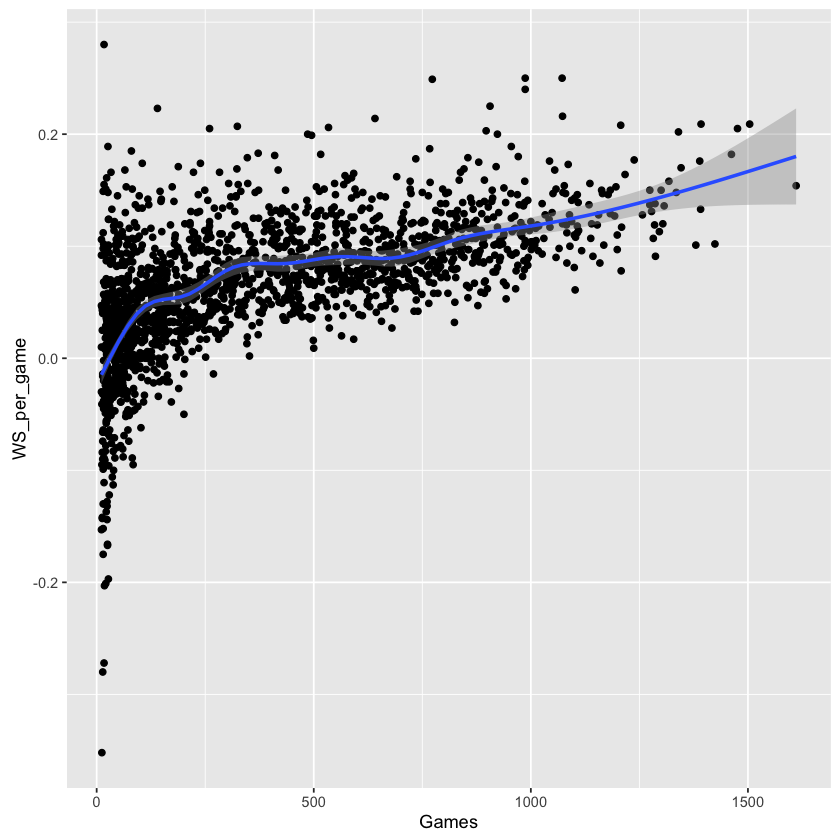

In [14]:
# After knocking out the players with 10 or fewer games played
newdf %>%
    ggplot(aes(x = Games, y = WS_per_game))+
        geom_point()+
        geom_smooth()

## Big difference and more nuance can be seen in the relationship between games and WS
The graph above with those players dropped reveals a stronger positive correlation more in line with expectations and reveals more trends in the data. We can see a pretty steady increase, but what's interesting is that the increase in win share per game for players with between 10 games to about 100 has a much sharper increase. I could delve into this more, but in the interest of space I'm going to move on. My theory is that this sharp increase though is related to the fact that there are 82 games in a season, thus players that make it through a whole season are more similar to one another (and thus a smaller slope for players with at least a season of play) than those with less than a full season where performances are more variable.

## Did this impact the t-test?
Did these players with less than 10 games to their name affect the t-test? Remember that the differences in mean for win share and win share per game between players that attended college and those that didn't was not statistically significant. Thus we couldn't reject the hypothesis with 95% (or some other standard) confidence that there was a true difference in the means. But now let's look at these t-tests after dropping some players. 

In [15]:
ndf <- newdf %>%
    filter(newdf$Draft_Yr >= 1989 & newdf$Draft_Yr < 2006)
t.test(ndf$WS_per_game ~ ndf$attend_college)


	Welch Two Sample t-test

data:  ndf$WS_per_game by ndf$attend_college
t = 2.886, df = 140.22, p-value = 0.00452
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.005696113 0.030475098
sample estimates:
mean in group 0 mean in group 1 
     0.08119820      0.06311259 


In [16]:
t.test(ndf$Win.Share ~ ndf$attend_college)


	Welch Two Sample t-test

data:  ndf$Win.Share by ndf$attend_college
t = 2.4351, df = 127.42, p-value = 0.01627
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  1.949069 18.851852
sample estimates:
mean in group 0 mean in group 1 
       32.32342        21.92296 


## Yep!
The impact of dropping players with less than 10 games had a huge impact on the p-values. Both t-tests are now significant at the 95% level and we can reject the null hypothesis that there is no difference in the means between players that attended college and those that didn't.

## But should players who barely played still be included?
My ultimate questions is how well GM's did in drafting players. Given this question, there is a strong argument that these players should be included in evaluating GM's drafting quality. I'm going to drop them though for two good reasons:
1. As stated earlier, these players are likely those that signed minimum 10 day contracts from the NBA, but these players were potentially not signed by the team that drafted them at very high rates. Many of these players were likely drafted, played summer league ball with a team, were cut and then drifted in the league for a season or two and maybe got on the court for a team in need. Given that these players are moving around so much, I think it's hard to credit a GM with having 'spotted' such players' talent when there is a high probability these players didn't even make it past summer league with the team that drafted them.
2. Contributions from these players is highly variable and equates to adding noise to the data. Whereas these players are all likely to have very low contributions to win share (just look at the graph below to see the strong relationship between games and win share), their win share per game stats are wildly disproportionate to their actual impact.

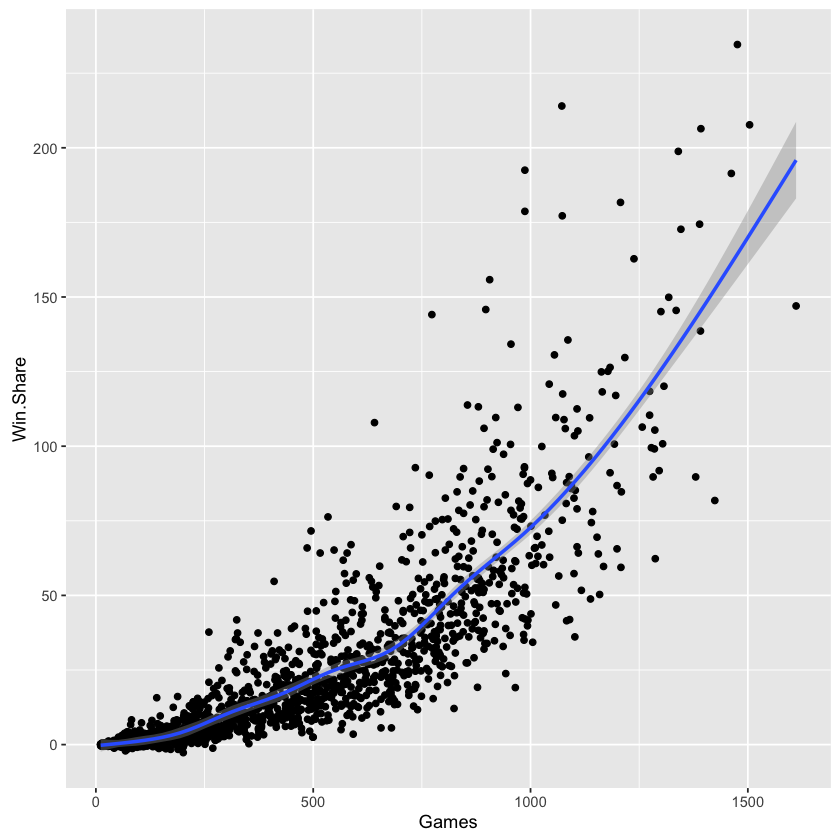

In [17]:
# WS - Games
newdf %>%
    ggplot(aes(x = Games, y = Win.Share))+
        geom_point()+
        geom_smooth()

## Turning to more relationships
Alright, now we can turn to looking for more relationships in the data to be sure they are included in the model. One thing that Adam brought up is that we should likely control for draft year in evaluating GM's since some draft classes will be stronger than others. We don't want to give too much credit to GM's who got to draft in stacked classes versus those that faced at best picking role players. So let's see how draft year varies with win share.

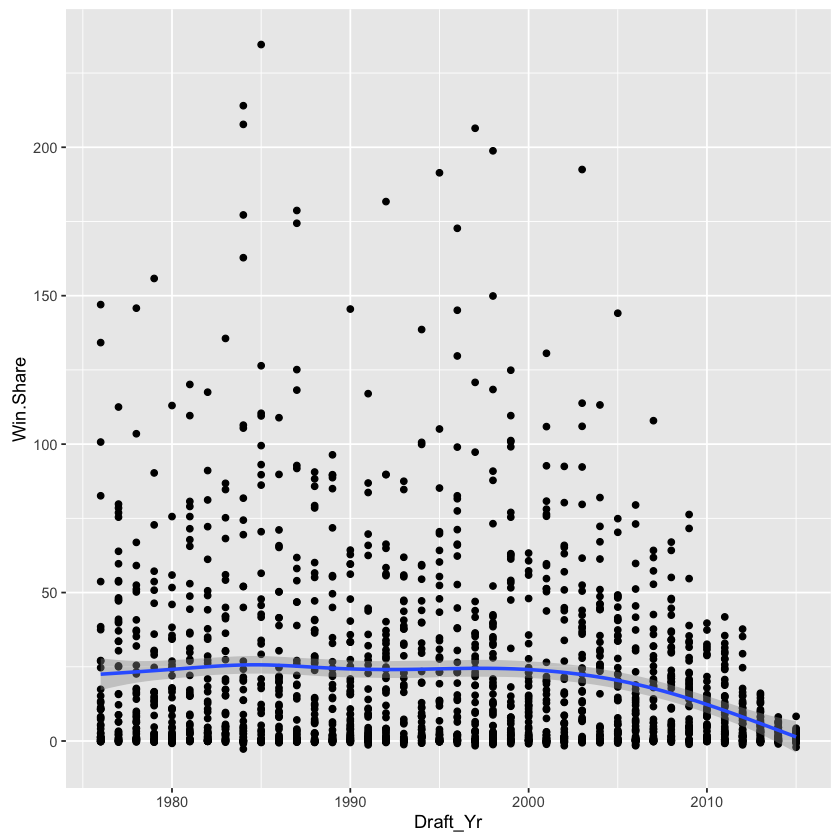

In [18]:
# WS - Draft Year
newdf %>%
    ggplot(aes(x = Draft_Yr, y = Win.Share))+
        geom_point()+
        geom_smooth()

## An argument for dummy variables for years since drafted
Huh. I think the above graph is pretty surprising, with not very much variation in win share over the years until a steady descent starting in about 2003. That descent makes a lot of sense since win share is a cumulative stat, players drafted in 2002 and later haven't had as much time to accumulate win share. This is a pretty solid argument to include dummy controls for when a player was drafted. Let's look to see if this plays out the same for win share per game.

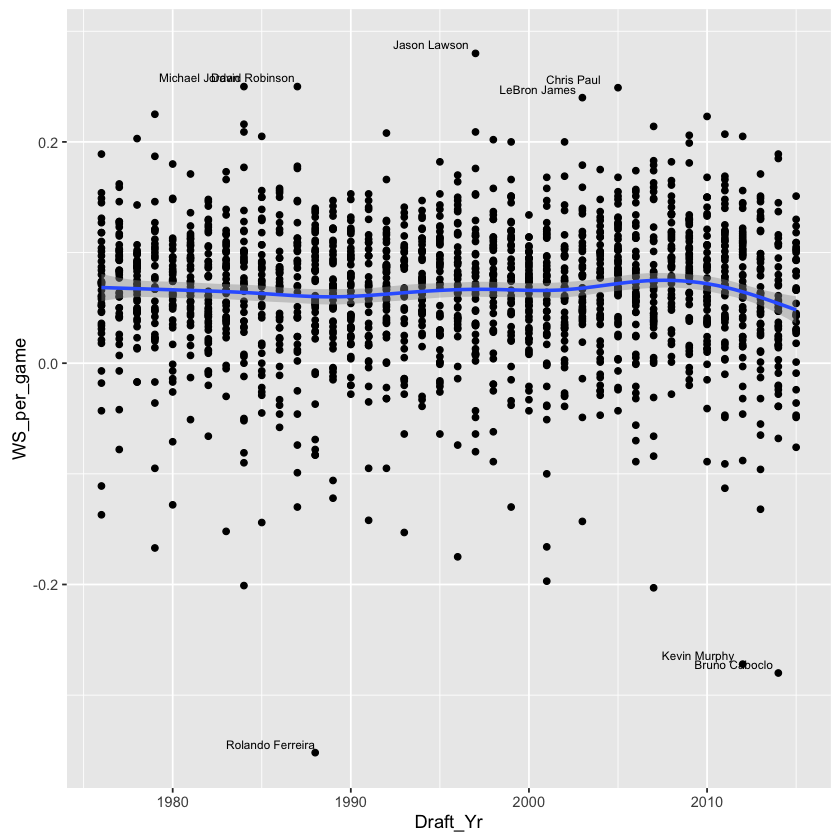

In [19]:
newdf %>%
    ggplot(aes(x = Draft_Yr, y = WS_per_game))+
        geom_point()+
        geom_smooth()+
        geom_text(data=subset(newdf, ((WS_per_game > 0.23 | WS_per_game < -0.25))), aes(Draft_Yr,WS_per_game,label=Player), size = 2.5, nudge_x = -2.5, nudge_y = 0.008)

## A little ebb 
Like win share, win share per game varies a little over the years based on draft year, but not as much as I would have thought based on the claims of stacked draft classes. This suggests that draft classes are pretty consistent in producing equitable talent, so perhaps the reason we think one draft class is terrible while another is amazing is more a psychological phenomenon based maybe around championships or the careers of the top drafted players? Anyway, this graph again shows the importance of including some dummy variables, though the downward decline for win share per game doesn't start till about 2010. This is interesting cause it suggests that it takes about 5 years (since our stats go through 2015) for players to adjust to the NBA and get their win share per game stats to about career average.
## Jason Lawson ????????????
I wanted to make note of the fact that Jason Lawson continues to be an outlier in this data. Remember some of the other players that were coming through the win share per game graphs earlier (Rakeem Christmas, Korleone Young, etc). They've disappeared, likely dropped after I eliminated players with less than ten games, but Lawson persists. So I googled him and checked out his [wikipedia][1]. He only played in 17 games (so possibly I should be dropping players with less than 20 games), but his stats are pretty good for his 4.7 average minutes. Wikipedia has pretty sparse information on him, but this [article][2] is interesting, that he was part of the 'Philly Fab Five' and was an absolute monster coming out of high school. Anyway, just another intersting story coming out from doing this analysis.
[1]: https://en.wikipedia.org/wiki/Jason_Lawson
[2]: http://articles.philly.com/1995-03-16/sports/25698261_1_toughness-simon-gratz-top-nba-prospect

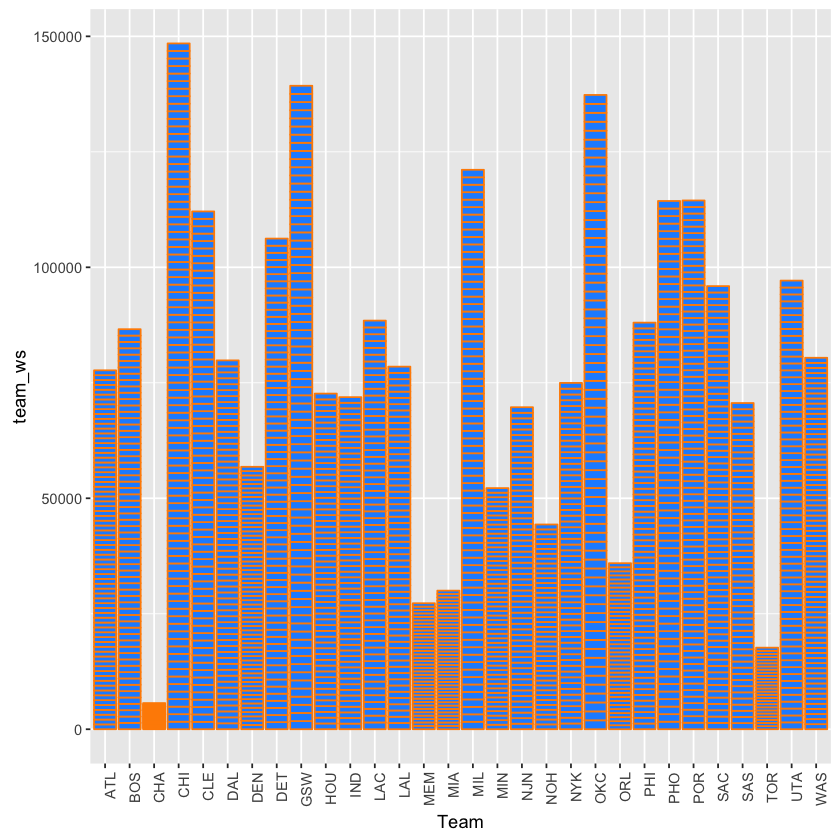

In [20]:
# WS - Team
newdf %>%
    group_by(Team) %>%
    mutate(team_ws = sum(Win.Share)) %>%
    ggplot(aes(x = Team, y = team_ws)) +
        geom_bar(stat = "identity", fill = "dodgerblue", color = "darkorange")+
        theme(axis.text.x = element_text(angle = 90, hjust = 1))

## What's this graph tell us?
When I first decided to graph teams total win share based on draft picks, I thought it'd be a pretty boring graph. Essentially this graph is a summation of the win share for every player a team drafted. I thought this would probably align pretty well with which teams have historically won over the last 40 years. But looking at the graph actually made me realize that there are clearly some teams that draft well, but there are many other teams that must be more than good enough in free agency and trading since the teams that have historically won over the last 40 years are not those at the top of the list (well other than Chicago). I'd like to be able to break the bars up to show how much a given player makes up of a team's total win share (something like [this][2]), but haven't found a way to do this in R yet.
Anyway, what's apparent in this graph is that Chicago drafted really well and won a lot (Michael Jordan and Horace Grant, and doesn't even include their draft day trade for Pippen). Surprisingly, the Golden State Warriors rank very high. Though they are a dominant team now, the influence of recent winning on total win share has not been fully felt yet. For much of the 90s and 00s they were not very good so I decided to look to see who they [drafted][1]. Sure enough, they drafted well, but often let future stars go early. The biggest names to get away: Robert Parish, Tim Hardaway, Penny Hardaway, and Vince Carter.

Two final notes about this graph:
1. Notice that Portland, despite missing out on Jordan and Durant, apparently still drafted well over the last 40 years.
2. The Lakers, despite winning five championships in the 00's and a few others in the 80's (though mostly with players drafted before '76), appear to not have necessarily drafted well. Granted, as stated earlier, this data doesn't include draft day trades, including that Kobe was drafted by Charlotte, but then traded almost immediately to the Lakers.

## Do GM's improve at drafting?
The next few graphs look at whether GM's improve at drafting by looking at the relationship between win share and the number of years a GM has drafted while controlling for the draft pick number.
[1]:http://www.basketball-reference.com/teams/GSW/draft.html
[2]: https://datajargon.com/2016/06/29/41/

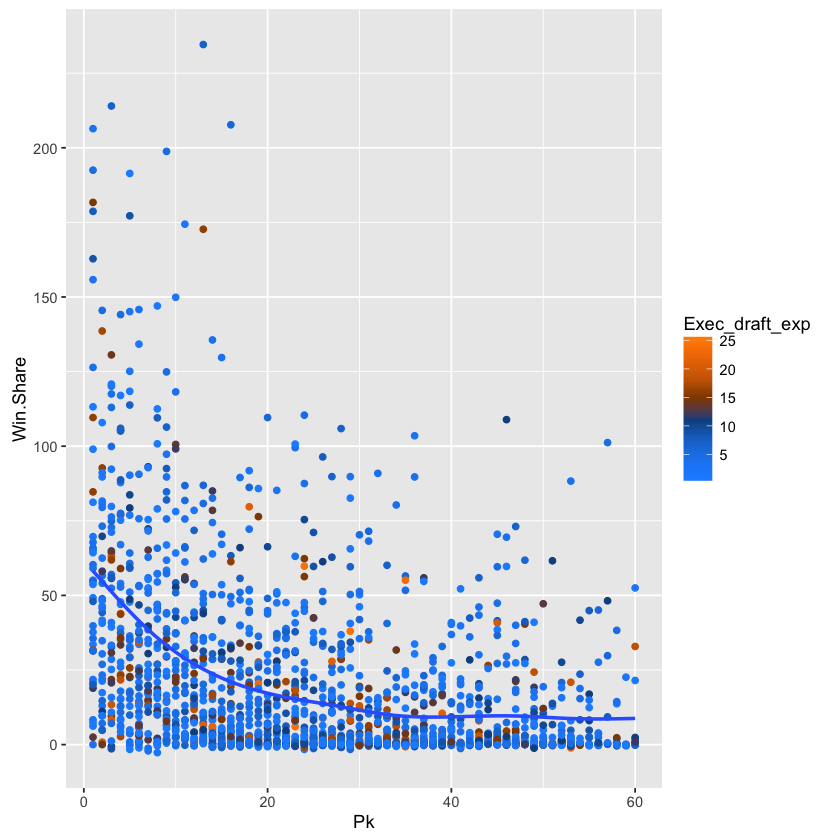

In [21]:
# WS - draft exp
newdf %>%
    ggplot(aes(x = Pk, y = Win.Share, color = Exec_draft_exp)) +
        geom_point()+
        geom_smooth(se = FALSE)+
        scale_colour_gradientn(colours=thunder)

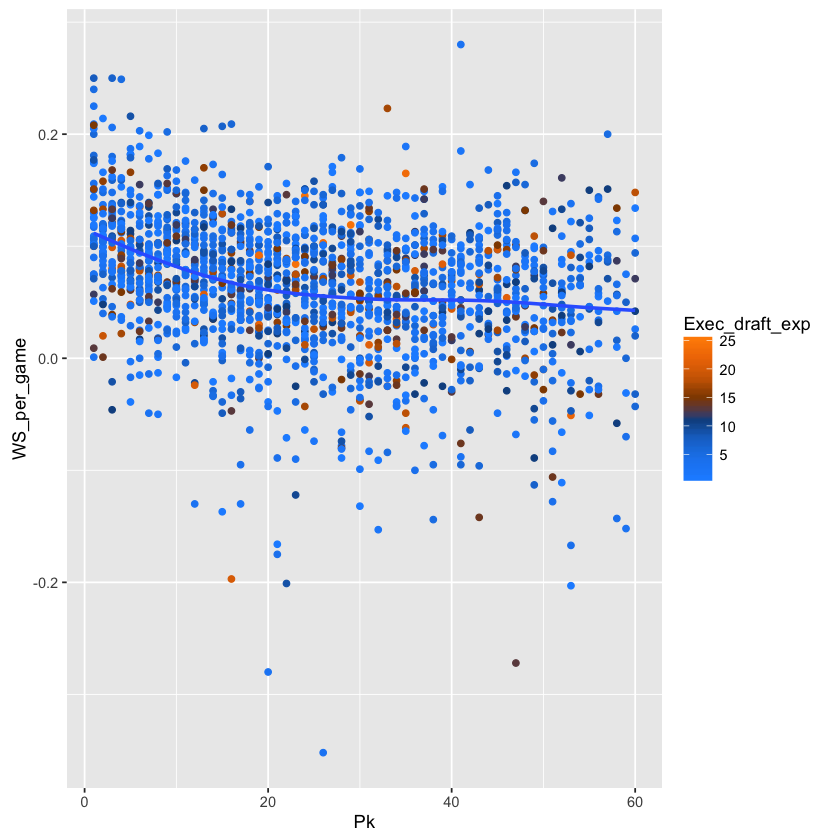

In [22]:
newdf %>%
    ggplot(aes(x = Pk, y = WS_per_game, color = Exec_draft_exp)) +
        geom_point()+
        geom_smooth(se = FALSE)+
        scale_colour_gradientn(colours=thunder)

## Doesn't seem to be a heavy correlation
In the above two graphs, if GM's with more experience were better at drafting we would expect there to be a concentration of orange dots all along and above the blue line, whereas blue dots would tend to be along and below the blue line. The blue line as a line of best fit is pretty close to the average win share per draft pick position. So if a GM was good at drafting and improving then as the number of years he drafted went up i.e. the dots representing his picks became more orange, we'd expect to see more and more of his dots above the blue line. the fact that we don't appears to indicate that drafting may be (1) pretty random and (2) that GM's are being evaluated by a lot more than how well they draft (which we certainly hope is true, though maybe Sam Hinkie will be validated in 5 years).

## Aside - note the difference in this graph as compared to similar in previous post
In the previous post I graphed win share per game against pick number and the relationship appeared nearly flat. Now that players with fewer than 10 games played were tossed, the relationship appears much stronger.

Warning message:
“Stacking not well defined when ymin != 0”

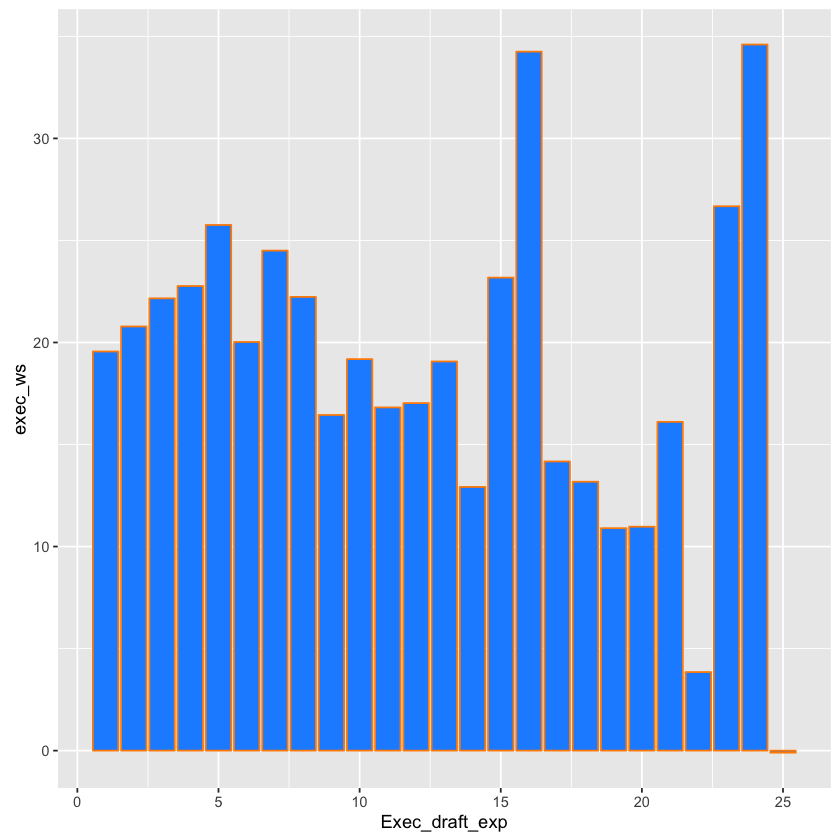

In [23]:
# Let's look at GM experience to win share though in a bar graph
newdf %>%
    group_by(Exec_draft_exp) %>%
    summarise(exec_ws = mean(Win.Share)) %>%
    ggplot(aes(x = Exec_draft_exp, y = exec_ws)) +
        geom_bar(stat="identity", fill = "dodgerblue", color = "darkorange")

## Lot's of noise
This bar graph groups the data such that we don't have to try and decipher clumped points in a graph. The graph seems to show a little bit of a relationship between GM drafting experience and win share (the y-axis is a sum of the win share for all executives with that much experience, so the first bar's height is the sum of the win share for every GM's first year of picks). As we can see, win share seems to increase over the first five years of a GM's career before beginning to decline and eventually entering what looks like randomness. 
There are a couple of arguments for this apparent relationship. From a labor perspective, we might argue that GM's are fairly motivated during those first few years and are learning a significant amount, but by year 5, motivation is waning a bit and they don't invest as much in drafting. Another potential explanation is that during the first few years GM's are learning and improving at picking players, but that by year 5 changes in league play alter what a GM should be using to evaluate draft picks. GM's, slow to realize the evolution of the game or wedded to what worked before lag behind in drafting to keep up with trends in the game. A final explanation, and the most likely I would think, is that good GM's that stick around may be improving at drafting, but by year five have built successful teams such that they are likely to be drafting at lower positions. This would only partly explain the graph though since the NBA simply rotated draft picks (rather than basing pick position on NBA record) for some of the dataset.
We can check to see if these differences in GM drafting quality are real, i.e. did GM's really draft that much better in their second year than in their first?

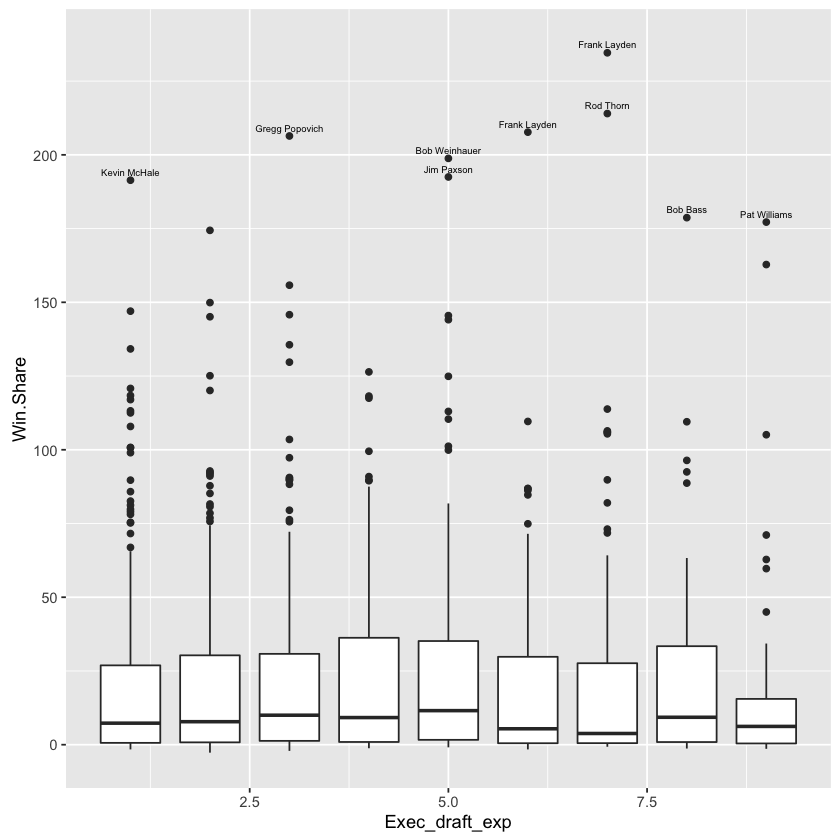

In [24]:
newdf %>%
    filter(Exec_draft_exp <= 9) %>%
    ggplot(aes(x = Exec_draft_exp, y = Win.Share)) +
        geom_boxplot(aes(group = Exec_draft_exp))+
        geom_text(data=subset(newdf, Win.Share > 175 & Exec_draft_exp <= 9), aes(Exec_draft_exp,Win.Share,label=Executive), size = 2, nudge_y = 2.8)

## Ability to draft != job retention
Box plots!!!! It wasn't till recently that I took seriously the fact that box plots could actually tell you quite a bit. This ignorance I think stems from when I was taught about them in middle school with my teacher thinking they were great because they included 'whiskers' and always drew them as cat faces. Despite this experience, I now recognize their value including here, where they pretty much dismiss the idea that there is any true difference in GM drafting quality from additional years of experience. Were the differences in bar height in the previous bar graph actually signifying significant differences in GM's ability to draft players with high potential win share, then we would expect these box plots to be more offset. The bar in the middle of the boxes representing the average win share of a player drafted by a GM with a given amount of experience is nearly uniform across years, and the interquartile ranges for the different years of drafting experience overlap quite a bit (though to be fair, since 0 is kind of a lower constraint, this pushes the IQR's to appear more similar). For a fuller analysis I should run t-tests looking at differences in means between years, but there isn't really space to do that here.
Note that I only plotted the first 9 years of GM experience given the wild variation in win share after that as illustrated in the bar graph. Also worth noting are the huge outliers in the above graph. For each year of experience there seems to be at least one huge outlier though no GM jumps out as consistently beating the odds at drastic rates. Only Frank Layden appears more than once as a huge outlier.

## We understand our variables and relationships better and can work to build a model
I've finally come to the end of this post. I hope it wasn't too boring, but all this is necessary foundation for building a model. We now understand the relationship between many of our variables and win share better so that in the next post I can implement a model and test for the best drafting GM's.